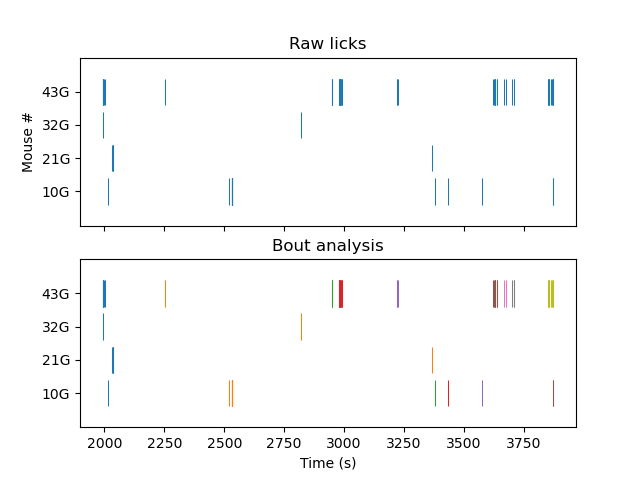

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from pntools import sampled
import beyelerlab as ab

%matplotlib widget

fdir = r'C:\Users\prane\Downloads\PhotoM groupe 1'
default_params = {
    'file_types'        : ('lick_times', 'isos', 'GCaMP'), # add RCaMP (or similar) at the end if you have that
    'use_names_from'    : 'GCaMP', # source file for using mouse names
    'col_selector'      : 'Mouse', # I manually renamed your isos file to be consistent with columns in the GCaMP file
    'mouse_col_offset'  : 11,
    'bout_th'           : 10, # s
    'target_sr'         : 30, # Hz
    'discard_initial_s' : 15, # seconds
    'detrend_lambda'    : 1e6,
    'f_bandpass'        : (0.2, 6),
}


d = ab.Dataset(fdir, **default_params)
p = d.params

_, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[0].eventplot([x() for x in d.lick_times.values()], linelengths=0.8)
ax[0].set_ylabel('Mouse #')
ax[0].set_title('Raw licks')

for m_count, this_licktimes in enumerate(d.lick_times.values()):
    bout_classes = this_licktimes.bout_classes()
    for bout_class in np.unique(bout_classes):
        ax[1].eventplot(np.asarray(this_licktimes())[bout_classes == bout_class], color=f'C{bout_class-1}', lineoffsets=m_count, linelengths=0.8)
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Bout analysis')

for this_ax in ax:
    this_ax.set_yticks((0, 1, 2, 3))
    this_ax.set_yticklabels([x.removeprefix('Mouse') for x in d.mouse_names])

Text(0.5, 1.0, 'Step 4: bandpass')

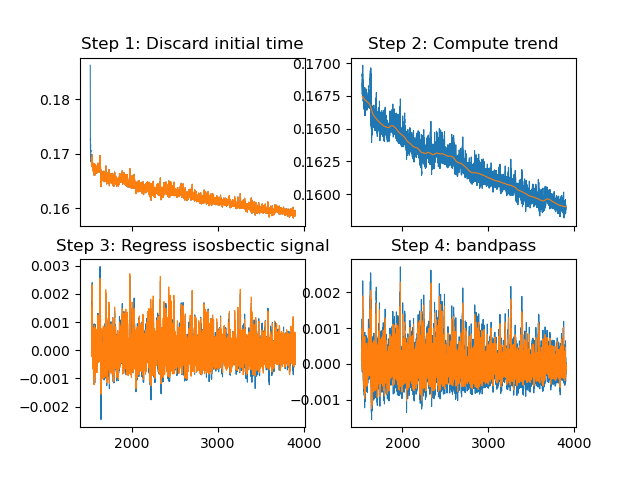

In [6]:
m = d('Mouse10G').GCaMP
m_ref = d('Mouse10G').isos[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda)
m_proc = m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda).regress(m_ref).bandpass(*p.f_bandpass)

_, ax = plt.subplots(2, 2, sharex=True)

ax[0, 0].plot(*m(''))
ax[0, 0].plot(*m[m._t0 + p.discard_initial_s:](''))
ax[0, 0].set_title('Step 1: Discard initial time')

ax[0, 1].plot(*m[m._t0 + p.discard_initial_s:](''))
ax[0, 1].plot(*m[m._t0 + p.discard_initial_s:].get_trend_airPLS(p.detrend_lambda)(''))
ax[0, 1].set_title('Step 2: Compute trend')

ax[1, 0].plot(*m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda)(''))
ax[1, 0].plot(*m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda).regress(m_ref)(''))
ax[1, 0].set_title('Step 3: Regress isosbectic signal')

ax[1, 1].plot(*m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda).regress(m_ref)(''))
ax[1, 1].plot(*m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda).regress(m_ref).bandpass(*p.f_bandpass)(''))
ax[1, 1].set_title('Step 4: bandpass')

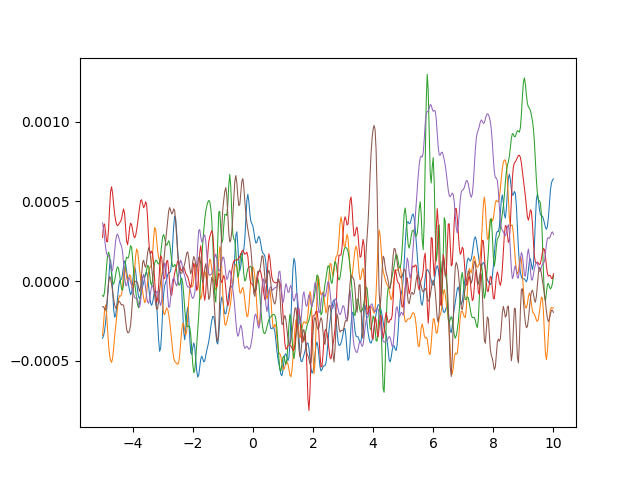

In [3]:
m_lickstart = d('Mouse10G').lick_times

event_win = sampled.Interval(-5., 10., sr=m_proc.sr)

f, ax = plt.subplots(1, 1)
for ev_start in m_lickstart.bout_start():
    ax.plot(event_win.t, m_proc[event_win + ev_start]())


In [14]:
np.mean([m_proc[event_win + ev_start]() for ev_start in m_lickstart.bout_start()], axis=0)

array([-6.50711523e-05, -4.26439585e-05, -2.51613581e-05, -1.54812446e-05,
       -1.07669763e-05,  6.30062898e-07,  2.69600114e-05,  5.84848343e-05,
        7.23948026e-05,  5.56631051e-05,  1.95296486e-05, -1.14950982e-05,
       -2.16530611e-05, -1.16077005e-05,  1.09470366e-05,  3.90933975e-05,
        6.40190661e-05,  7.44840616e-05,  6.76772928e-05,  5.73608598e-05,
        6.16151833e-05,  8.02297582e-05,  9.15090992e-05,  7.66749462e-05,
        4.30031971e-05,  1.63871231e-05,  1.30105547e-05,  2.54113263e-05,
        3.66341567e-05,  3.99980187e-05,  4.06335441e-05,  4.38516815e-05,
        4.93216240e-05,  5.41356426e-05,  5.44194645e-05,  4.49673693e-05,
        2.55988363e-05,  9.40579273e-06,  1.54246687e-05,  4.66656593e-05,
        8.14982010e-05,  9.52582172e-05,  8.75330585e-05,  7.93716303e-05,
        8.44192314e-05,  9.28154403e-05,  8.69273082e-05,  6.46271941e-05,
        4.05316390e-05,  2.88268543e-05,  3.12087067e-05,  3.89312758e-05,
        4.00377777e-05,  

1

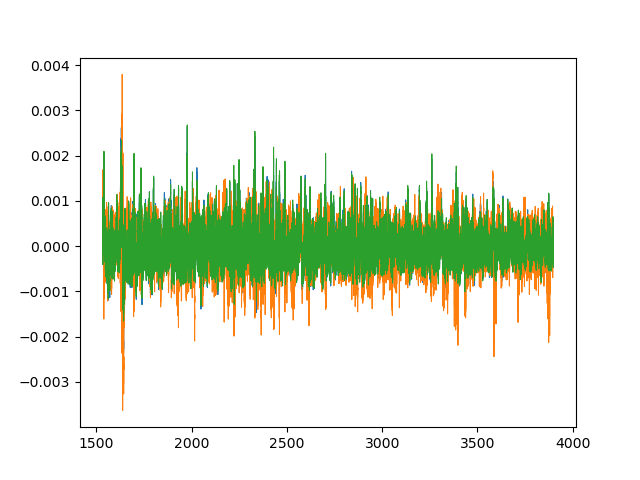

In [29]:
m = d('Mouse10G').GCaMP
m_ref = d('Mouse10G').isos[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda)
m_proc = m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda).bandpass(*p.f_bandpass)

m_ref_proc1 = m_ref[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda)
m_proc1 = m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda)

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(m_ref_proc1().reshape(-1, 1), m_proc1())
pred_with_iso = reg.coef_[0]*m_ref_proc1() + reg.intercept_
m_proc1_reg = m_proc1._clone(m_proc1() - pred_with_iso, ('Regressed with reference', m_ref_proc1))


# plt.figure()
# plt.plot(m_proc1.t, m_proc1())
# plt.plot(m_proc1.t, reg.predict(m_proc1.t.reshape(-1, 1)))

plt.figure()
plt.plot(m_proc1.t, m_proc1())
plt.plot(m_proc1.t, m_ref_proc1())
plt.plot(m_proc1_reg.t, m_proc1_reg())

m_proc1().ndim